# NMAR-Adjusted Validation

In [1]:
import numpy as np
import tensorflow as tf

In [8]:
import os
import sys
from pathlib import Path
SCRIPT_DIR = os.path.dirname(os.path.abspath("__init__.py"))
SRC_DIR = Path(SCRIPT_DIR).parent.absolute()
print(SRC_DIR)
sys.path.append(os.path.dirname(SRC_DIR))
sys.path.append(os.path.dirname(str(SRC_DIR) + '/models'))

from src.config import BASE_WINDOW_Y_CROP_1, BASE_WINDOW_Y_CROP_2, BASE_WINDOW_X_CROP_1, BASE_WINDOW_X_CROP_2

/Users/yannis/PycharmProjects/WeRec3D/src


In [3]:
from src.models.model2 import create_model
from src.data_loaders.loading import get_test_sets
from src.experiments_evaluation.validation_helpers import calc_temporal_errors, calc_total_errors, calc_spatial_errors, scale_slp_back, scale_t2m_back, reshape_for_modelling, get_median_pred_days
from src.experiments_evaluation.plotting import visualize_quantitative_spatial, visualize_quantitative_temporal

In [4]:
MODEL_PATH = str(SRC_DIR) + '/experiments_evaluation/ex7.2_emc_mnar_training/model_checkpoint/p99/'

F = 5
H = 32
W = 64
CH = 5  # t2m, msl, msk1, msk2, elev
BS = 4
PERCENTAGE = "99"

In [5]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = create_model(f=F, h=H, w=W, ch=CH, bs=BS)    
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), run_eagerly=None)
    model.load_weights(MODEL_PATH)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Input image batch shape: (4, 5, 32, 64, 5)
Number output channels: 2
Layer1: (4, 5, 32, 64, 64)
Layer2: (4, 5, 16, 32, 128)
Layer3: (4, 5, 16, 32, 128)
Layer4: (4, 5, 8, 16, 256)
Layer5: (4, 5, 8, 16, 256)
Layer6: (4, 5, 8, 16, 256)
Layer7: (4, 5, 8, 16, 256)
Layer8: (4, 5, 8, 16, 256)
Layer9: (4, 5, 8, 16, 256)
Layer10: (4, 5, 8, 16, 256)
Layer11: (4, 5, 8, 16, 256)
Layer12: (4, 5, 8, 16, 256)
Layer13: (4, 5, 16, 32, 128)
Layer14: (4, 5, 16, 32, 128)
Layer15: (4, 5, 32, 64, 64)
Layer16: (4, 5, 32, 64, 32)
Layer17: (4, 5, 32, 64, 2)


In [10]:
test_x, test_y = get_test_sets()
print(test_x.shape, test_y.shape)

Loading test variables file: test.npy
Loading test mask file: test_mask_99p.npy
Creating x and y validation sets...
(1826, 40, 68, 5) (1826, 40, 68, 4)


In [18]:
x = reshape_for_modelling(test_x, seq_shift_reshape=True)
y = reshape_for_modelling(test_y, seq_shift_reshape=False)
print(x.shape)
print(y.shape)

# On CPU raises error if seq / BS not int
x = x[:1820]
y = y[:1820, ..., :2]

print(x.shape)
print(y.shape)

(1821, 5, 32, 64, 5)
(1825, 32, 64, 4)
(1820, 5, 32, 64, 5)
(1820, 32, 64, 2)


In [19]:
pred = model.predict(x, batch_size=BS)
print(pred.shape)

2024-02-20 11:19:43.495792: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


455/455 [==============================] - 174s 382ms/step
(1820, 5, 32, 64, 2)


In [20]:
median_pred = get_median_pred_days(pred, 1820)
print(median_pred.shape)

(1820, 32, 64, 2)


## Quantitative on Climatology

In [21]:
total_error, t2m_error, msl_error = calc_total_errors(y, median_pred)
print(f"Total error: {total_error}")
print(f"t2m error: {t2m_error}")
print(f"msl error: {msl_error}")

Total error: 0.15622224139245852
t2m error: 0.12926824821066035
msl error: 0.1831762345742565


In [22]:
print(f"t2m error scaled: {scale_t2m_back(t2m_error, for_error=True)}")
print(f"msl error scaled: {scale_slp_back(msl_error, for_error=True)}")

t2m error scaled: 1.1498797190400387
msl error scaled: 201.1298868535831


In [23]:
temp_total_err, temp_t2m_err, temp_slp_err = calc_temporal_errors(y, median_pred)
spat_total_err, spat_t2m_err, spat_slp_err = calc_spatial_errors(y, median_pred)

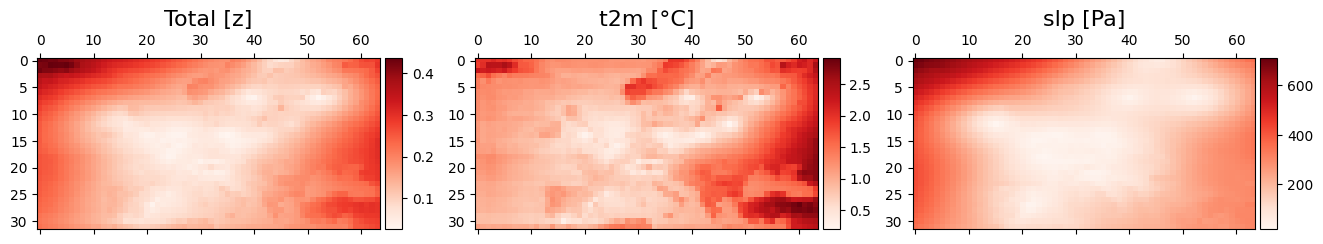

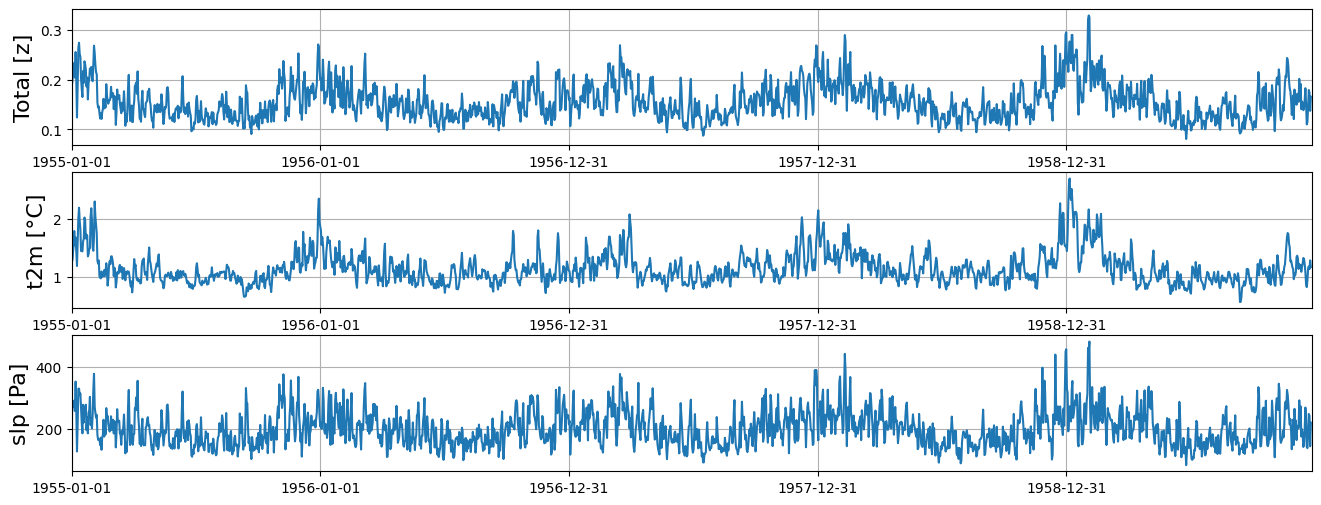

In [25]:
visualize_quantitative_spatial(spat_total_err,
                               spat_t2m_err,
                               spat_slp_err,
                               scale_back=True,
                               save_file_name="figures/spatial_nmar_adjusted.png")

visualize_quantitative_temporal(temp_total_err,
                                temp_t2m_err,
                                temp_slp_err,
                                scale_back=True,
                                save_file_name="figures/temporal_nmar_adjusted.png")

## Quantitative on Anomaly

In [26]:
from src.config import TA_MU, TA_SIGMA, SLP_MU, SLP_SIGMA

In [27]:
# In °C or Pa
unit_test_ymean = np.load("../data_sets/ymean_sets/test_ymean.npy")
unit_test_ymean = unit_test_ymean[:1820]

print(unit_test_ymean.shape)
print(median_pred.shape)
print(y.shape)

(1820, 32, 64, 2)
(1820, 32, 64, 2)
(1820, 32, 64, 2)


In [28]:
normalized_test_ymean = (unit_test_ymean - np.array([TA_MU, SLP_MU])) / np.array([TA_SIGMA, SLP_SIGMA])

norm_pred_anom = median_pred - normalized_test_ymean
norm_gt_anom = y - normalized_test_ymean

total_normalized_anomaly_mae = np.mean(np.abs(norm_pred_anom - norm_gt_anom))
t2m_normalized_anomaly_mae = np.mean(np.abs(norm_pred_anom[..., 0] - norm_gt_anom[..., 0]))
slp_normalized_anomaly_mae = np.mean(np.abs(norm_pred_anom[..., 1] - norm_gt_anom[..., 1]))


print(f"Total normalized Anomaly MAE: {total_normalized_anomaly_mae}")
print(f"T2M normalized Anomaly MAE: {t2m_normalized_anomaly_mae}")
print(f"SLP normalized Anomaly MAE: {slp_normalized_anomaly_mae}")
print("")

print(f"T2M unit Anomaly MAE: {scale_t2m_back(t2m_normalized_anomaly_mae, for_error=True)}")
print(f"SLP unit Anomaly MAE: {scale_slp_back(slp_normalized_anomaly_mae, for_error=True)}")

Total normalized Anomaly MAE: 0.15622224139245852
T2M normalized Anomaly MAE: 0.1292682482106603
SLP normalized Anomaly MAE: 0.18317623457425677

T2M unit Anomaly MAE: 1.1498797190400383
SLP unit Anomaly MAE: 201.1298868535834


## Qualitative

In [29]:
import pandas as pd
from src.experiments_evaluation.plotting import visualize_qualitative_set

In [32]:
test_dates = pd.date_range(start="1950-01-01", periods=test_x.shape[0], freq="D")
quali_indicies = np.arange(181, 186)

quali_dates = [str(s).split(" ")[0] for s in test_dates[quali_indicies]]

quali_x = test_x[quali_indicies, BASE_WINDOW_Y_CROP_1:BASE_WINDOW_Y_CROP_2, BASE_WINDOW_X_CROP_1:BASE_WINDOW_X_CROP_2]
# Add batchsize format
quali_x = np.repeat(np.expand_dims(quali_x, axis=0), BS, axis=0)
quali_y = test_y[quali_indicies, BASE_WINDOW_Y_CROP_1:BASE_WINDOW_Y_CROP_2, BASE_WINDOW_X_CROP_1:BASE_WINDOW_X_CROP_2]
print(quali_x.shape, quali_y.shape)

(4, 5, 32, 64, 5) (5, 32, 64, 4)


In [33]:
quali_pred = model.predict(quali_x)

print(quali_pred.shape)
# All samples in batch are the same anyway...
quali_pred = quali_pred[0]
# Set x back to one sample
quali_x =quali_x[0]
print(quali_pred.shape)
print(quali_x.shape)

2024-02-20 11:28:13.246325: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1/1 [==============================] - 1s 582ms/step
(4, 5, 32, 64, 2)
(5, 32, 64, 2)
(5, 32, 64, 5)


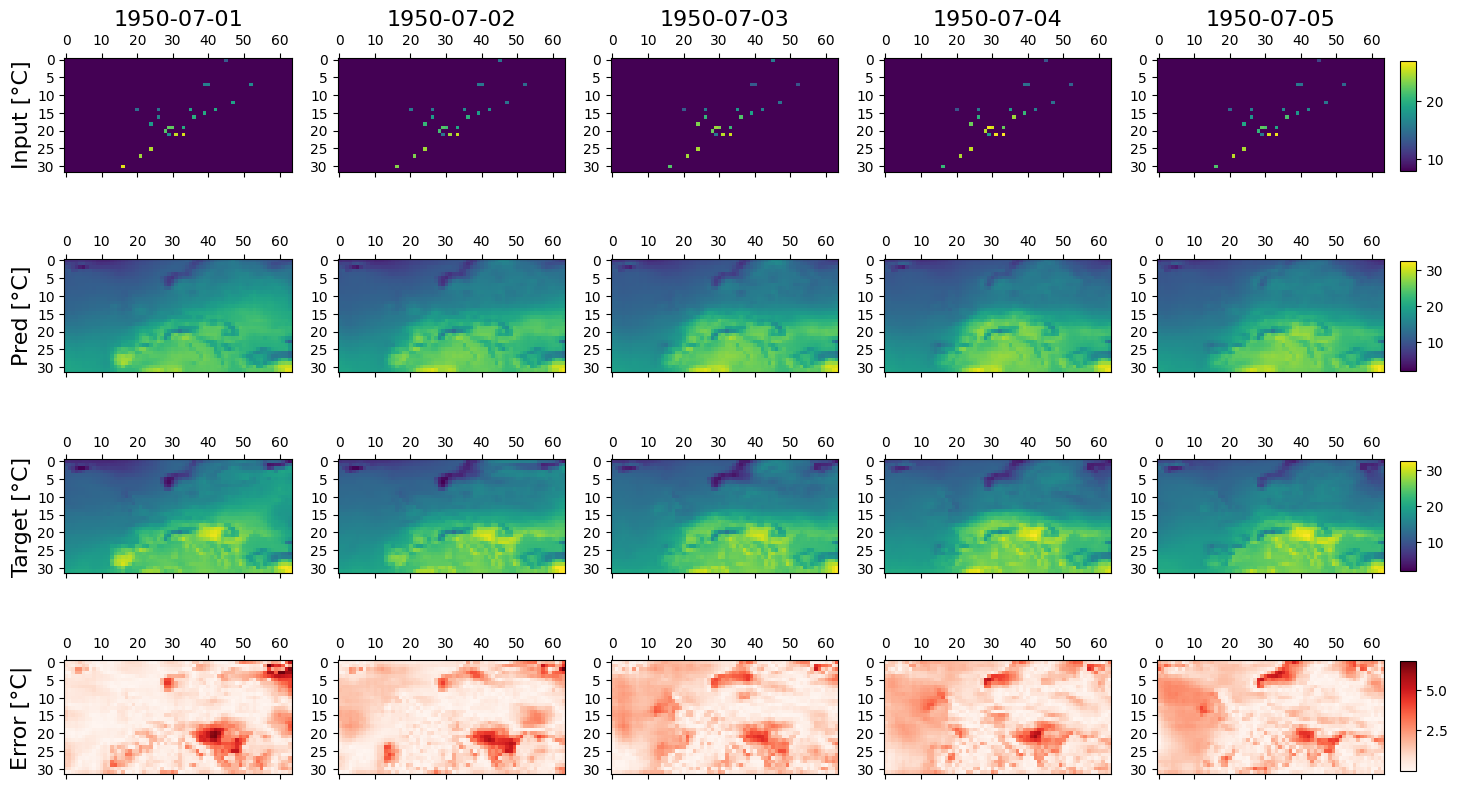

In [34]:
visualize_qualitative_set(quali_x, quali_y, quali_pred, quali_dates, "t2m",
                          scale_back=True,
                          save_file_name="figures/qualitative_t2m_nmar_adjusted.png")

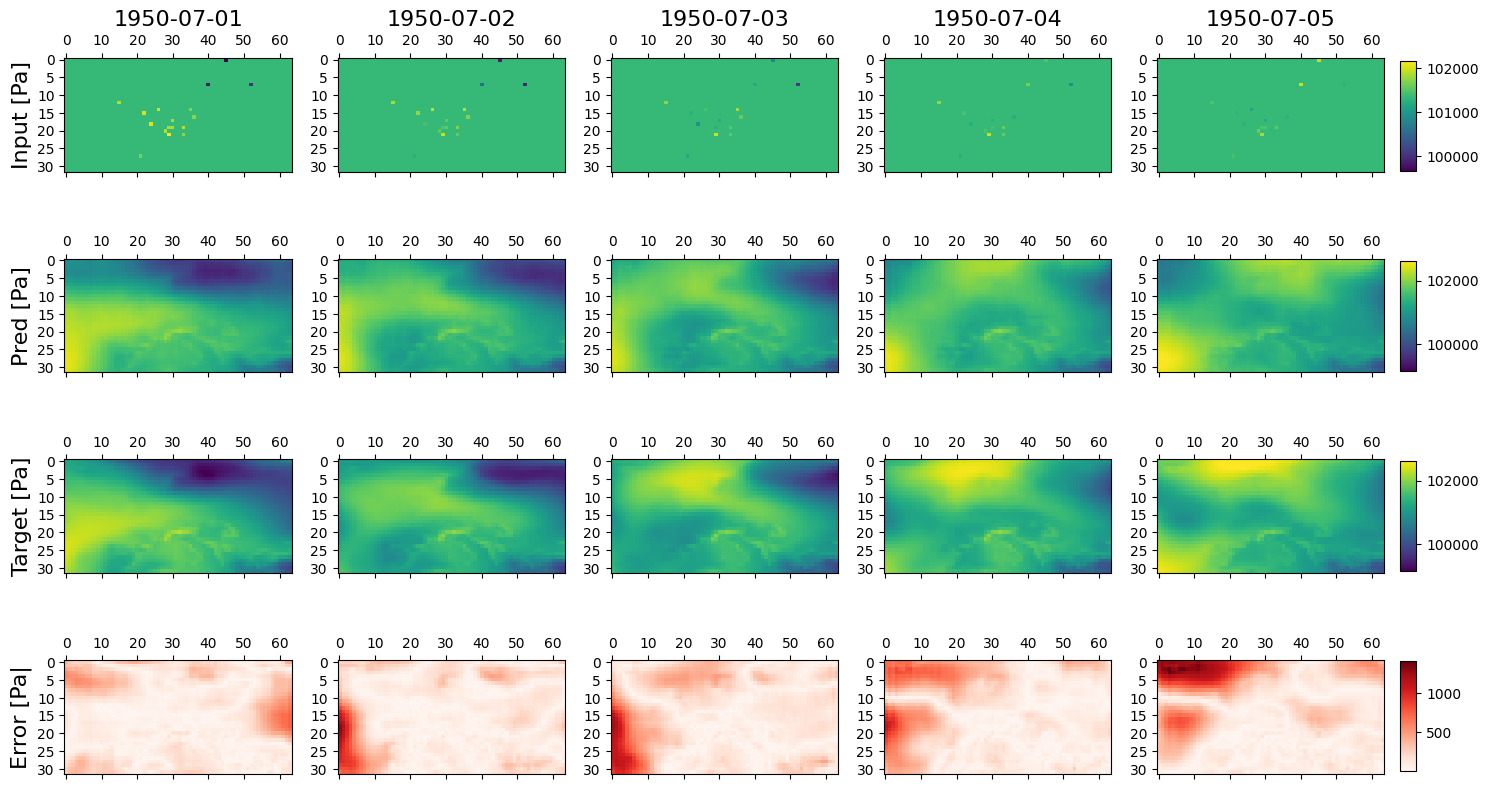

In [35]:
visualize_qualitative_set(quali_x, quali_y, quali_pred, quali_dates, "slp",
                          scale_back=True,
                          save_file_name="figures/qualitative_slp_nmar_adjusted.png")